In [1]:
from torch_snippets import inspect, show, np, torch, nn
from torchvision.models import resnet50
import requests
from PIL import Image

model = resnet50(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model = model.eval()

url = "https://lionsvalley.co.za/wp-content/uploads/2015/11/african-elephant-square.jpg"
original_image = Image.open(requests.get(url, stream=True).raw).convert("RGB")
original_image = np.array(original_image)
original_image = torch.Tensor(original_image)

/home/xujialiu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/xujialiu/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/xujialiu/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:29<00:00, 3.50MB/s]


In [2]:
image_net_classes = "https://gist.githubusercontent.com/yrevar/942d3a0ac09ec9e5eb3a/raw/238f720ff059c1f82f368259d1ca4ffa5dd8f9f5/imagenet1000_clsidx_to_labels.txt"
image_net_classes = requests.get(image_net_classes).text
image_net_ids = eval(image_net_classes)
image_net_classes = {i: j for j, i in image_net_ids.items()}

In [10]:
image_net_classes

{'tench, Tinca tinca': 0,
 'goldfish, Carassius auratus': 1,
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias': 2,
 'tiger shark, Galeocerdo cuvieri': 3,
 'hammerhead, hammerhead shark': 4,
 'electric ray, crampfish, numbfish, torpedo': 5,
 'stingray': 6,
 'cock': 7,
 'hen': 8,
 'ostrich, Struthio camelus': 9,
 'brambling, Fringilla montifringilla': 10,
 'goldfinch, Carduelis carduelis': 11,
 'house finch, linnet, Carpodacus mexicanus': 12,
 'junco, snowbird': 13,
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea': 14,
 'robin, American robin, Turdus migratorius': 15,
 'bulbul': 16,
 'jay': 17,
 'magpie': 18,
 'chickadee': 19,
 'water ouzel, dipper': 20,
 'kite': 21,
 'bald eagle, American eagle, Haliaeetus leucocephalus': 22,
 'vulture': 23,
 'great grey owl, great gray owl, Strix nebulosa': 24,
 'European fire salamander, Salamandra salamandra': 25,
 'common newt, Triturus vulgaris': 26,
 'eft': 27,
 'spotted salamander, Ambystoma macu

In [7]:
from torchvision import transforms as T
from torch.nn import functional as F

normalize = T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
denormalize = T.Normalize(
    [-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], [1 / 0.229, 1 / 0.224, 1 / 0.225]
)


def image2tensor(input):
    x = normalize(input.clone().permute(2, 0, 1) / 255.0)[None]
    return x


def tensor2image(input):
    x = (denormalize(input[0].clone()).permute(1, 2, 0) * 255.0).type(torch.uint8)
    return x

In [5]:
def predict_on_image(input):
    model.eval()
    show(input)
    input = image2tensor(input)
    pred = model(input)
    pred = F.softmax(pred, dim=-1)[0]
    prob, clss = torch.max(pred, 0)
    clss = image_net_ids[clss.item()]
    print(f"PREDICTION: `{clss}` @ {prob.item()}")

In [8]:
from tqdm import trange

losses = []
modified_images = []
desired_targets = ["lemon", "comic book", "sax, saxophone"]


def attack(image, model, target, epsilon=1e-6):
    input = image2tensor(image)
    input.requires_grad = True
    pred = model(input)
    loss = nn.CrossEntropyLoss()(pred, target)
    loss.backward()
    losses.append(loss.mean().item())
    output = input - epsilon * input.grad.sign()
    output = tensor2image(output)
    del input
    return output.detach()


for target in desired_targets:
    target = torch.tensor([image_net_classes[target]])
    image_to_attack = original_image.clone()
    for _ in trange(10):
        image_to_attack = attack(image_to_attack, model, target)
    modified_images.append(image_to_attack)

100%|██████████| 10/10 [00:01<00:00,  7.56it/s]


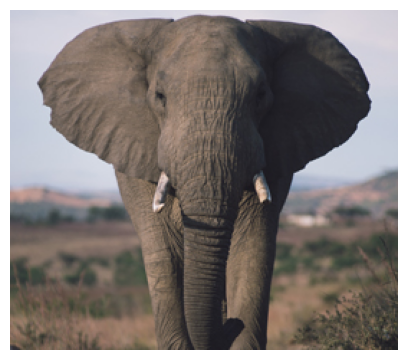

PREDICTION: `African elephant, Loxodonta africana` @ 0.5234400033950806
══════════════════════════════════════════════════════════════════
tensor([[[200., 203., 218.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [207., 204., 215.],
         [207., 204., 215.],
         [207., 204., 215.]],

        [[199., 202., 217.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [207., 204., 215.],
         [207., 204., 215.],
         [207., 204., 215.]],

        [[200., 203., 218.],
         [200., 203., 218.],
         [200., 203., 218.],
         ...,
         [208., 205., 216.],
         [208., 205., 216.],
         [208., 205., 216.]],

        ...,

        [[ 73.,  71.,  74.],
         [ 58.,  56.,  61.],
         [ 58.,  54.,  53.],
         ...,
         [ 34.,  32.,  37.],
         [ 35.,  33.,  38.],
         [ 38.,  39.,  43.]],

        [[ 76.,  73.,  82.],
         [ 57.,  54.,  63.],
         [ 49.,  47.,  50.],


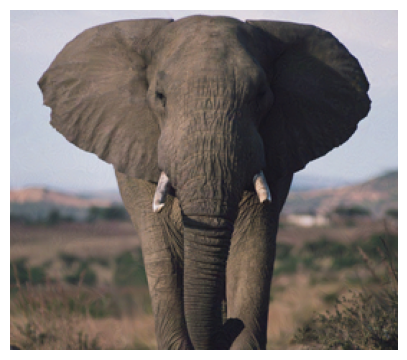

PREDICTION: `lemon` @ 0.999993085861206
══════════════════════════════════════════════════════════════════
tensor([[[197, 198, 214],
         [196, 200, 213],
         [196, 197, 212],
         ...,
         [202, 198, 209],
         [200, 197, 210],
         [201, 197, 207]],

        [[195, 200, 212],
         [196, 200, 216],
         [196, 199, 213],
         ...,
         [201, 200, 209],
         [201, 198, 210],
         [200, 195, 210]],

        [[197, 201, 213],
         [194, 199, 214],
         [196, 200, 215],
         ...,
         [205, 200, 210],
         [201, 198, 209],
         [200, 197, 209]],

        ...,

        [[ 71,  66,  68],
         [ 54,  51,  53],
         [ 55,  49,  47],
         ...,
         [ 28,  27,  33],
         [ 27,  28,  33],
         [ 33,  34,  38]],

        [[ 73,  68,  75],
         [ 50,  45,  56],
         [ 42,  38,  40],
         ...,
         [ 28,  29,  33],
         [ 24,  26,  31],
         [ 28,  29,  33]],

        [[ 78,  78,

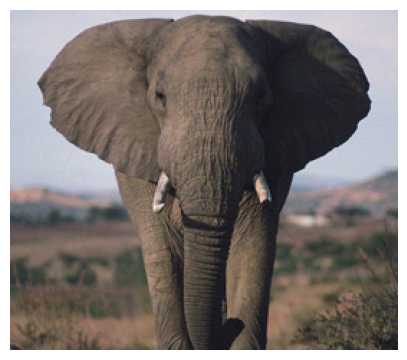

PREDICTION: `comic book` @ 0.9999934434890747
══════════════════════════════════════════════════════════════════
tensor([[[195, 195, 211],
         [199, 199, 212],
         [200, 199, 216],
         ...,
         [204, 199, 211],
         [203, 200, 211],
         [200, 198, 211]],

        [[199, 201, 213],
         [200, 202, 214],
         [199, 199, 209],
         ...,
         [204, 197, 210],
         [203, 196, 209],
         [203, 198, 212]],

        [[196, 199, 217],
         [198, 198, 212],
         [197, 196, 209],
         ...,
         [201, 196, 208],
         [204, 199, 212],
         [204, 198, 212]],

        ...,

        [[ 64,  64,  71],
         [ 49,  48,  59],
         [ 52,  51,  52],
         ...,
         [ 28,  27,  33],
         [ 30,  28,  31],
         [ 35,  36,  40]],

        [[ 67,  70,  81],
         [ 50,  50,  61],
         [ 40,  41,  46],
         ...,
         [ 31,  28,  31],
         [ 26,  28,  29],
         [ 32,  33,  34]],

        [[ 72

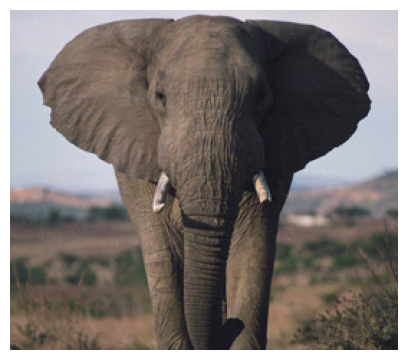

PREDICTION: `sax, saxophone` @ 0.9999992847442627
══════════════════════════════════════════════════════════════════
tensor([[[197, 200, 214],
         [198, 198, 210],
         [196, 198, 213],
         ...,
         [204, 200, 210],
         [199, 198, 211],
         [199, 197, 209]],

        [[197, 195, 211],
         [199, 202, 213],
         [198, 197, 211],
         ...,
         [204, 200, 207],
         [202, 200, 212],
         [201, 200, 213]],

        [[194, 195, 209],
         [198, 196, 209],
         [196, 196, 209],
         ...,
         [205, 201, 209],
         [205, 199, 211],
         [198, 196, 207]],

        ...,

        [[ 69,  69,  69],
         [ 51,  52,  57],
         [ 50,  46,  48],
         ...,
         [ 29,  25,  29],
         [ 31,  27,  34],
         [ 32,  32,  36]],

        [[ 72,  70,  76],
         [ 48,  48,  58],
         [ 40,  38,  43],
         ...,
         [ 32,  30,  32],
         [ 32,  28,  29],
         [ 31,  31,  31]],

        [

In [9]:
for image in [original_image, *modified_images]:
    predict_on_image(image)
    inspect(image)